<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/FinalProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In our collaborative project, we aim to develop an Emotion Detection model. Our primary goal is to create a robust model capable of accurately recognizing eight distinct emotions conveyed through facial expressions.

Please refer to the accompanying illustration for a visual representation of our project's purpose. We endeavor to discern various emotions from facial images through our model.

# Data Review and Processing
There are 5,500 + images with 8 emotions categories – anger, contempt, disgust, fear, happiness, neutrality, sadness and surprise. All images contain grayscale human face (or sketch). Each image is 224 x 224 pixel grayscale in PNG format.

Link for the data:
https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?select=happiness

In [81]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
# import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt
import itertools


In [82]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [83]:
# All the classes of emotions we have
classeses = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classeses.append(i)
classeses

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

In [41]:
# Data loading
classes = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')

# Initialize empty lists for features (transformed images) and labels
features = []
labels = []
def create_train():
    for i, photo in enumerate(classes):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_pil = cv2.imread(img_path)

            if img_pil is None:
                print("Error loading image:", img_path)
                continue
            #Append the original image and its label to the list
            features.append(np.array(img_pil))
            labels.append(label)

create_train()
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 524 images
Label 1 sadness: 746 images
Label 2 fear: 570 images
Label 3 surprise: 785 images
Label 4 contempt: 208 images
Label 5 happiness: 1406 images
Label 6 anger: 890 images
Label 7 disgust: 439 images


In [29]:
# Brief visualization of the dataset
def plot_first_n_images(images, labels, classes, n=5):
    num_unique_labels = len(np.unique(labels))  # Get the number of unique labels
    fig, axes = plt.subplots(num_unique_labels, n, figsize=(n*2, num_unique_labels*2))

    # Initialize a dictionary to store image indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Plot 'n' images for each unique label
    for label_idx, label in enumerate(np.unique(labels)):
        indices = label_indices[label][:n]  # Get the first 'n' indices for this label
        for img_idx, img_index in enumerate(indices):
            axes[label_idx, img_idx].imshow(images[img_index], cmap='gray')
            axes[label_idx, img_idx].set_title(f"Label: {classes[label]}")
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

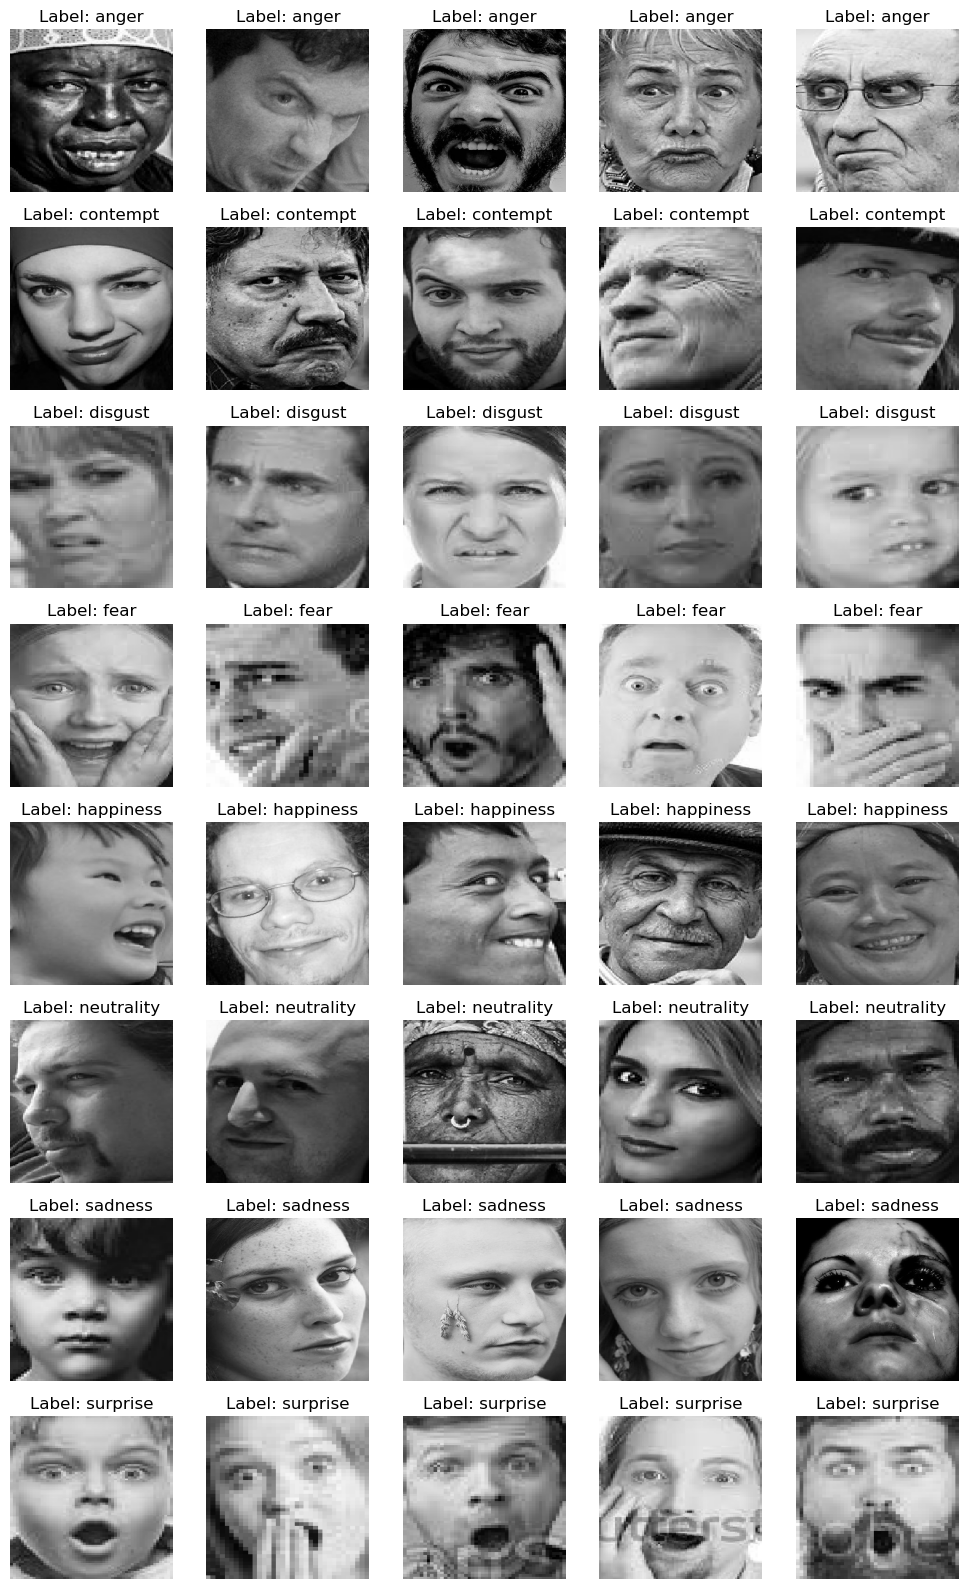

In [ ]:
# Brief visualization of the dataset
plot_first_n_images(features, labels, classeses, n=5)

In [84]:
#Data processing performed
# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

In [151]:
# Your existing code to load images
features_or = []
labels_or = []
train_data_or = []
failed_indices = []
def create_images():
    for i, photo in enumerate(classeses):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE to improve the contrast locally
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)

            # If no faces are detected with CLAHE, try standard histogram equalization
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(image_to_use, face)
                combined_region = extract_and_combine_regions(image_to_use, landmarks)

                # Append the combined image and its label to the list
                features_or.append(combined_region)  # Append the combined region
                labels_or.append(label)

                train_data_or.append([combined_region, label])
            else:
                failed_indices.append(i)

create_images()
# Print the label counts
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 419 images
Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 3 surprise: 610 images
Label 4 contempt: 142 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Label 7 disgust: 292 images


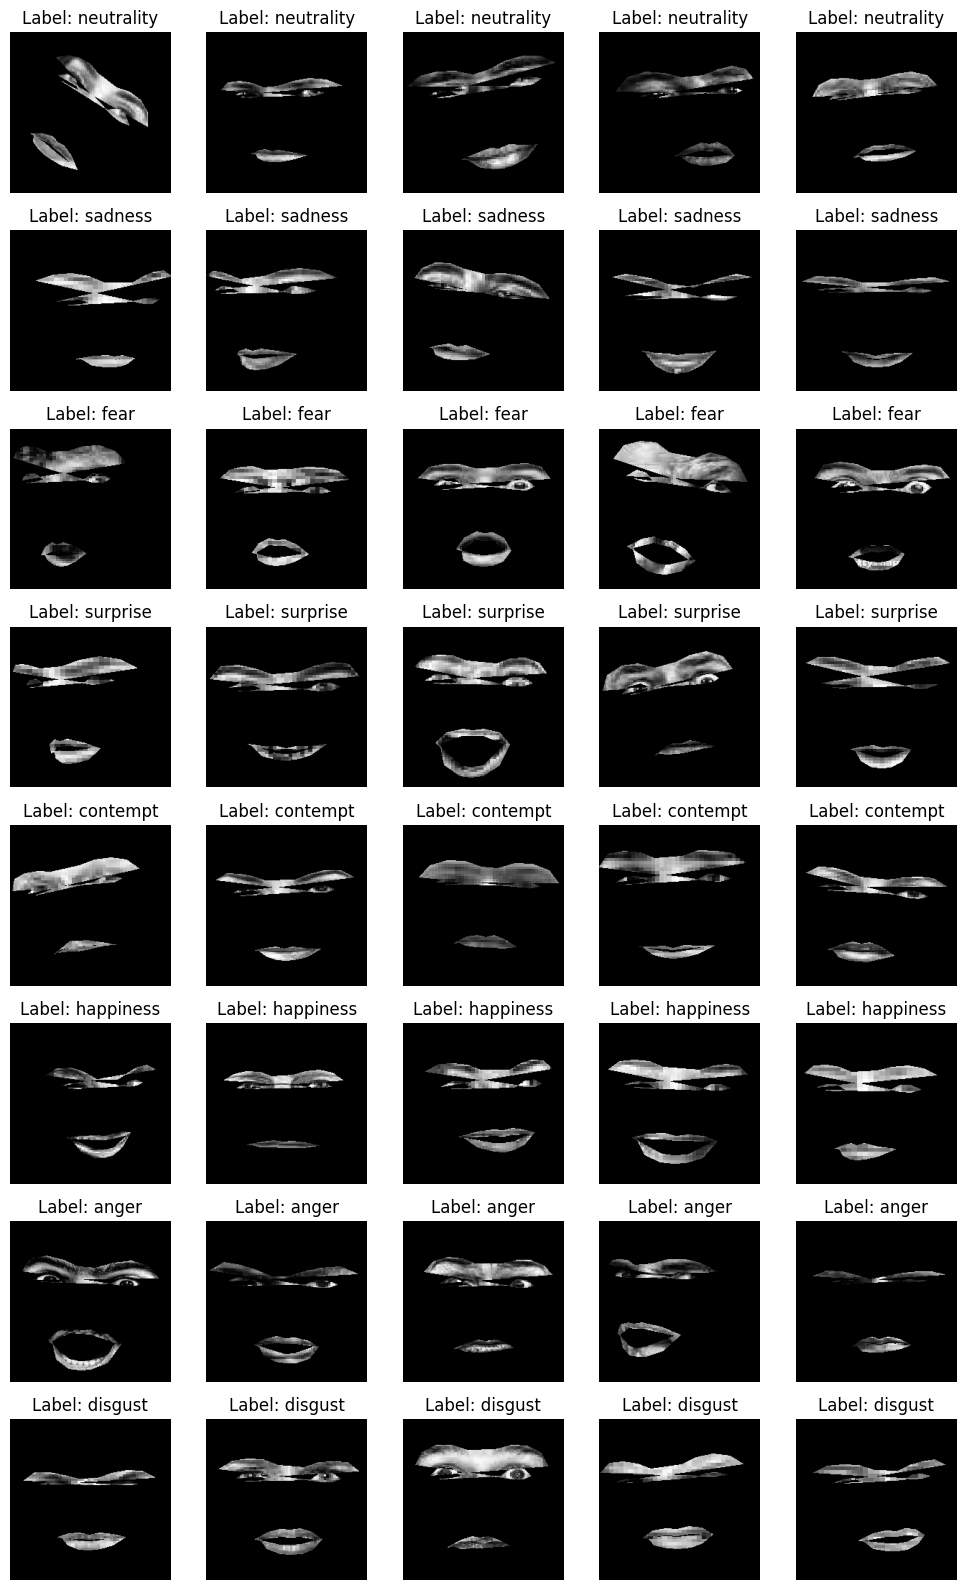

In [43]:
plot_first_n_images(features_or, labels_or, classeses, n=5)

In [152]:
# Extract sadness and happiness
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [1, 5]
for i in desired_labels:
  print("Class: ", classeses[i])
# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Class:  sadness
Class:  happiness
Label 1 sadness: 448 images
Label 5 happiness: 896 images
Filtered Features Shape: (1344, 224, 224)
Filtered Labels Shape: (1344,)


In [153]:
# Two class
labels_filtered = np.array(labels_filtered)
# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 5] = 1
np.unique(labels_filtered)

array([0, 1])

In [154]:
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])
# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

def split_and_prepare_dataset(features, labels, transform, train_percent=0.80, val_percent=0.10):
    # Use Counter to get the count of each label in the dataset
    label_counts = Counter(labels)

    # Dictionary to store the indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Dictionary to store the indices for each set
    train_indices = []
    val_indices = []
    test_indices = []

    # Iterate over unique labels and distribute their indices among train, val, and test sets
    for label, indices in label_indices.items():
        label_size = len(indices)
        train_size = int(label_size * train_percent)
        val_size = int(label_size * val_percent)

        # Add indices to each set
        train_indices.extend(indices[:train_size])
        val_indices.extend(indices[train_size:(train_size + val_size)])
        test_indices.extend(indices[(train_size + val_size):])

    # Create Subset datasets based on the sampled indices
    train_dataset = prepare_dataset(features[train_indices], labels[train_indices], transform)
    val_dataset = prepare_dataset(features[val_indices], labels[val_indices], transform)
    test_dataset = prepare_dataset(features[test_indices], labels[test_indices], transform)

    return train_dataset, val_dataset, test_dataset

In [155]:
# split data
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_filtered, labels_filtered, transform)

In [156]:
# Check the length of each dataset
train_length = len(combined_train_dataset)
val_length = len(combined_val_dataset)
test_length = len(combined_test_dataset)

print(f"Training set length: {train_length} samples")
print(f"Validation set length: {val_length} samples")
print(f"Test set length: {test_length} samples")

Training set length: 1074 samples
Validation set length: 133 samples
Test set length: 137 samples


In [91]:
train_labels = combined_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the training dataset
label_counts_train = Counter(train_labels)
# Print the counts for each label
for label, count in label_counts_train.items():
    print(f"Label {label} : {count} images")

Label 0 : 268 images
Label 1 : 537 images


In [92]:
# Data Augmentation in train data
# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Flip with a probability of 1 (always flip)
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

def balance_dataset_with_augmentation(original_train_dataset, augmentation_transforms):
    # Count the number of images for each unique label in the training set
    label_counts_train = Counter(original_train_dataset.tensors[1].numpy())

    # Determine the maximum count among all labels
    max_count = max(label_counts_train.values())

    # Apply data augmentation to balance the dataset
    augmented_images = []
    augmented_labels = []

    for label, count in label_counts_train.items():
        # Calculate the number of augmentations needed for each label
        augmentations_needed = max_count - count

        # Filter images and labels for the current label
        label_indices = [i for i, l in enumerate(original_train_dataset.tensors[1].numpy()) if l == label]
        label_images = original_train_dataset.tensors[0][label_indices]
        label_labels = original_train_dataset.tensors[1][label_indices]

        # Apply data augmentation to reach the desired count
        for _ in range(augmentations_needed):
            random_index = np.random.choice(len(label_images))
            augmented_image = augmentation_transforms(label_images[random_index])
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    # Convert augmented data to tensors
    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

    # Combine the original and augmented data
    balanced_train_dataset = TensorDataset(torch.cat([original_train_dataset.tensors[0], augmented_images]),
                                           torch.cat([original_train_dataset.tensors[1], augmented_labels]))

    return balanced_train_dataset


In [93]:
# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (neutrality): 537 images
Label 1 (sadness): 537 images


In [ ]:
# Create dataloader
Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

In [94]:
#
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
      all_predicted.extend(predicted.view(-1).cpu().numpy())
      all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy =  correct / total
    return accuracy, all_predicted, all_labels

In [95]:
class CNNetResidual3(nn.Module):
    def __init__(self, num_classes, numresidual1,numresidual2):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, numresidual1)
        )

        self.downconv2 = nn.Sequential(
            nn.Conv2d((32+numresidual1), 128, kernel_size=7, padding=1,stride = 2),  # Fix the number of input channels
            nn.BatchNorm2d(128),
            nn.Dropout(0.3),  #add dropout
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(128, numresidual2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear((128+numresidual2) * 13 * 13, 1024),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

        self.name = "CNNetResidual3"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)

        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First 1x1 Convolution
        # self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.relu1 = nn.ReLU()

        # Second 3x3 Convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        # out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(x))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out

In [96]:
class CombinedCNN(nn.Module):
    def __init__(self, num_classes):
        super(CombinedCNN, self).__init__()

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        self.name = "CombinedCNN"
    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

In [97]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [98]:
# Define train function
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300, num_classes=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = '/content/gdrive/My Drive/ColabNotebooks/new'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch],_,_ = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch],_,_ = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")
        print(f"Saved model checkpoint: {model_path}")
        torch.cuda.empty_cache()
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Compute the confusion matrix after the final epoch
    _, val_predicted, val_labels = evaluate(model, val_loader)
    cm = confusion_matrix(val_labels, val_predicted)
    new_class = []
    for i in desired_labels:
        new_class.append(classes[i])
    class_names = list(new_class)  # Replace with your class names
    cm_figure = plot_confusion_matrix(cm, class_names)
    plt.show()

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title(f"Training and Validation Loss - {num_classes} Classes")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(f"Training and Validation Accuracy - {num_classes} Classes")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Quantitative Results for 2 classes: Happiness and Sad

The best accuracy for 2 classes is balance data with normal CNN model, best validation accuracy 0.88, with corresponding test data accuracy 0.84. The correspoding unbalance data has best validation accuracy 0.86. But the model with residual block's accuracy is slighter lower then normal CNN model. The corresponding code is as follow.

Training Begin...

Epoch 1: Train Acc: 0.67, Train Loss: 0.7067 | Val Acc: 0.67, Val Loss: 0.6054
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch0
Epoch 2: Train Acc: 0.67, Train Loss: 0.6361 | Val Acc: 0.67, Val Loss: 0.5947
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch1
Epoch 3: Train Acc: 0.67, Train Loss: 0.6320 | Val Acc: 0.67, Val Loss: 0.5930
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch2
Epoch 4: Train Acc: 0.67, Train Loss: 0.6397 | Val Acc: 0.67, Val Loss: 0.6020
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch3
Epoch 5: Train Acc: 0.67, Train Loss: 0.6287 | Val Acc: 0.67, Val Loss: 0.5774
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch4
Epoch 6: Train Acc: 0.68, Train Loss: 0.5829 | Val 

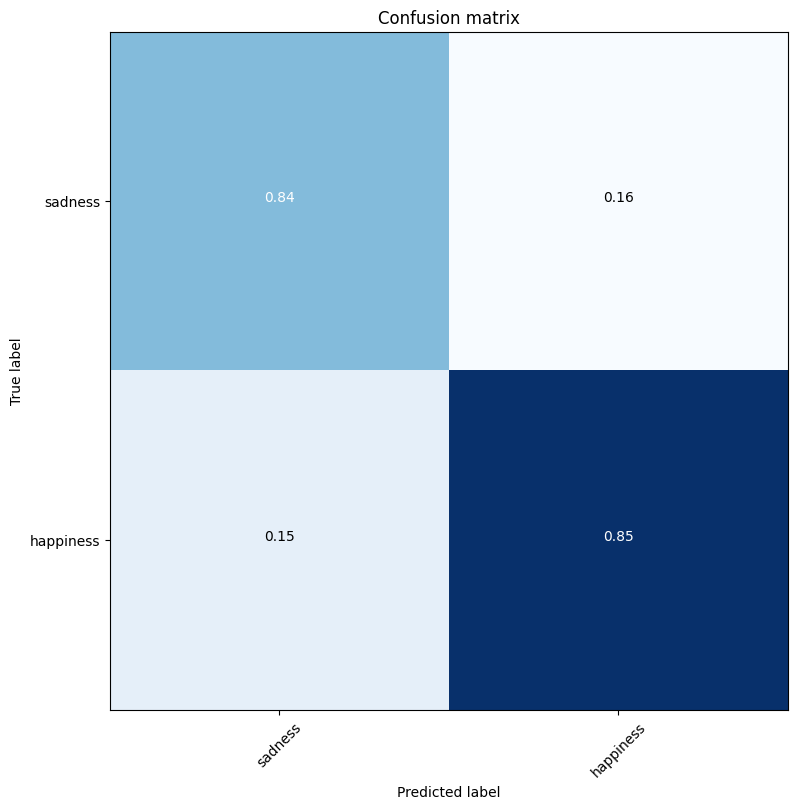

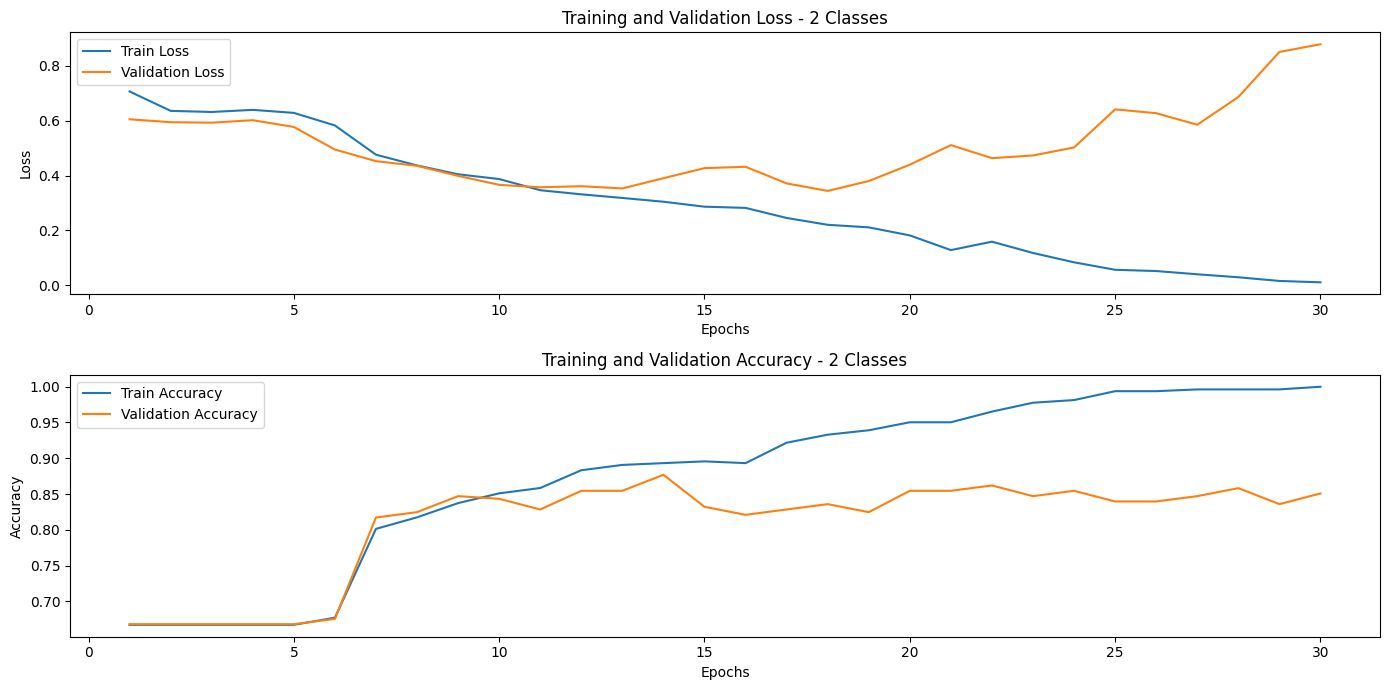

In [105]:
# Normal CNN model with balanced data
use_cuda = True
num_classes = 2
combined_model = CombinedCNN(2)
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

Training Begin...

Epoch 1: Train Acc: 0.83, Train Loss: 0.9152 | Val Acc: 0.33, Val Loss: 1.6116
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr0.0001_epoch0
Epoch 2: Train Acc: 0.88, Train Loss: 0.3760 | Val Acc: 0.76, Val Loss: 0.4824
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr0.0001_epoch1
Epoch 3: Train Acc: 0.89, Train Loss: 0.3032 | Val Acc: 0.76, Val Loss: 0.3845
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr0.0001_epoch2
Epoch 4: Train Acc: 0.87, Train Loss: 0.2875 | Val Acc: 0.79, Val Loss: 0.4682
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr0.0001_epoch3
Epoch 5: Train Acc: 0.92, Train Loss: 0.2336 | Val Acc: 0.84, Val Loss: 0.3665
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr0.0001_epoch4
Epoch 6: Train Acc: 0.94, Train Loss

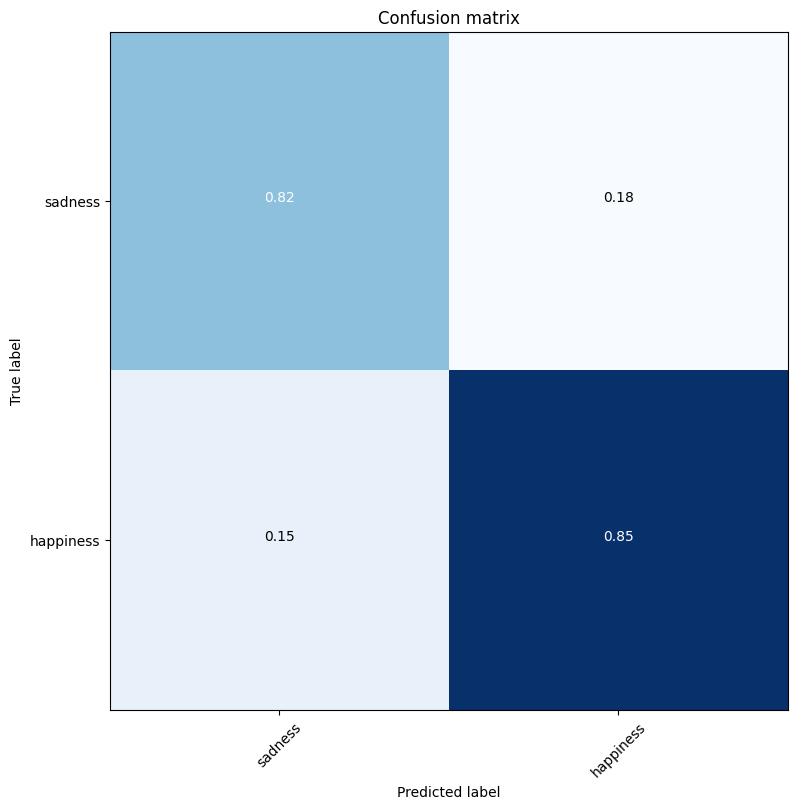

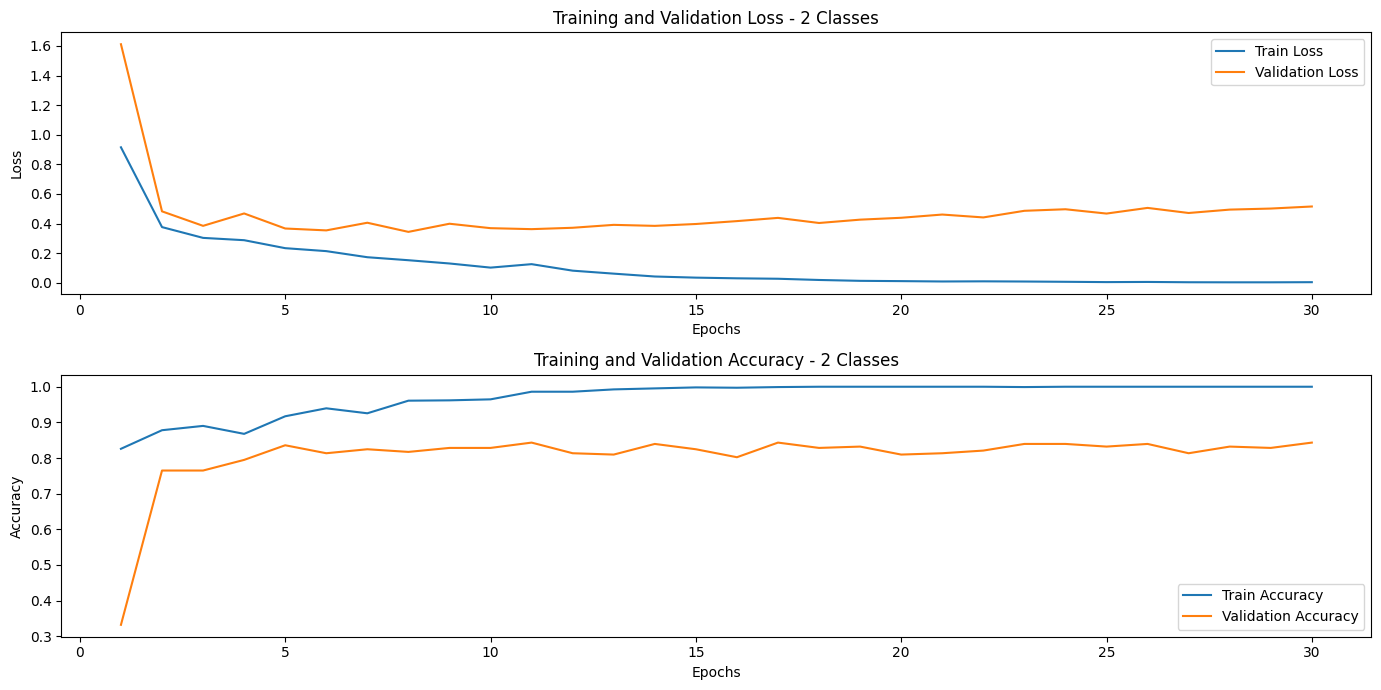

In [101]:
# Residual block model with unbalanced data
use_cuda = True
num_classes = 2
combined_model = CNNetResidual3(2,8,12)
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=30, num_classes=2)

Training Begin...

Epoch 1: Train Acc: 0.67, Train Loss: 0.6395 | Val Acc: 0.67, Val Loss: 0.6038
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch0
Epoch 2: Train Acc: 0.67, Train Loss: 0.6178 | Val Acc: 0.67, Val Loss: 0.5262
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch1
Epoch 3: Train Acc: 0.80, Train Loss: 0.5111 | Val Acc: 0.80, Val Loss: 0.4125
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch2
Epoch 4: Train Acc: 0.83, Train Loss: 0.4274 | Val Acc: 0.81, Val Loss: 0.3667
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch3
Epoch 5: Train Acc: 0.83, Train Loss: 0.3974 | Val Acc: 0.80, Val Loss: 0.3735
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch4
Epoch 6: Train Acc: 0.85, Train Loss: 0.3739 | Val 

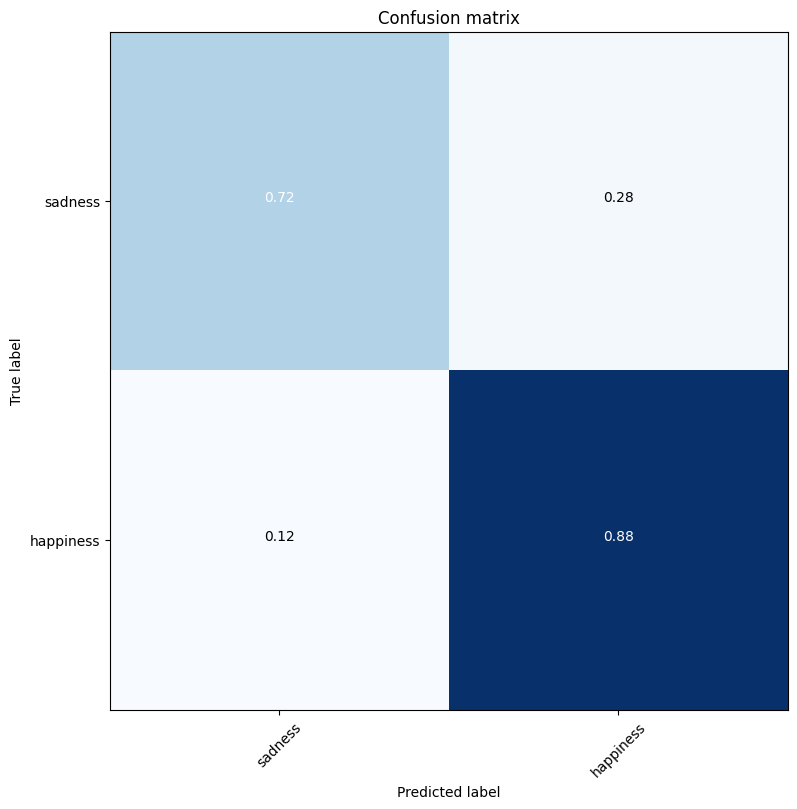

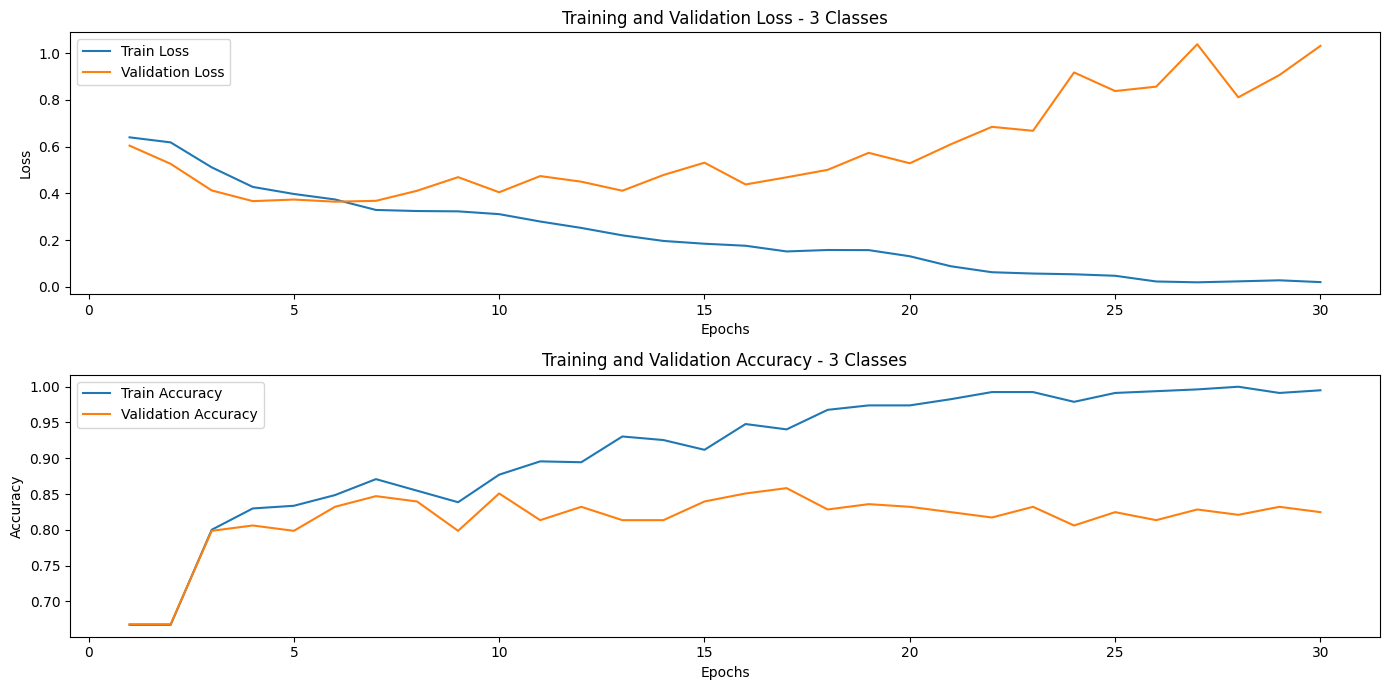

In [102]:
# Normal CNN model with not balanced data
use_cuda = True
num_classes = 2
combined_model = CombinedCNN(2)
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

In [103]:
def testevaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    model.eval()  # Set the model to evaluation mode

    for inputs, labels in loader:
        inputs = inputs.unsqueeze(0)
        inputs = inputs.cuda()  # Move inputs to GPU
        labels = labels.cuda()  # Move labels to GPU

        outputs = model(inputs)
        predicted = outputs.max(1, keepdim=True)[1]
        total += inputs.shape[0]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()


    model.train()  # Set the model back to training mode
    return correct / total

In [106]:
# load your best model
best_model2class = CombinedCNN(2)
best_model2class.load_state_dict(torch.load('/content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch13.pt'))

<All keys matched successfully>

In [111]:
# give the accuracy for test data
use_cuda = True
test_acc = testevaluate(best_model2class, combined_test_dataset)
print("Test Acc {:.2f}%".format(test_acc))

Test Acc 0.84%


# Quantitative Results for 4 classes Happiness, Sad, Surprise and Anger

The best accuracy for 4 classes is balance data with normal CNN model, best validation accuracy 0.69, with corresponding test data accuracy 0.65. The correspoding unbalance data has best validation accuracy 0.67. But the model with residual block's accuracy is slighter lower then normal CNN model, with best accuracy 0.67. We surpringly find balanced data set does not increase total accuracy much. But it indeed change some emotion accuracy. Before the data has been balanced the accuracy for Sade, surprise , happy and anger emotion is 0.37, 0.63, 0.77, 0.63. After balance the corresponding accuracy has been changed to 0.53, 0.76, 0.75, 0.5.

In [112]:
# Four classes: sadness, surprise, happiness, anger
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
#desired_labels = [1, 2, 5, 6]
desired_labels = [1, 3, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 1 sadness: 448 images
Label 3 surprise: 610 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Filtered Features Shape: (2539, 224, 224)
Filtered Labels Shape: (2539,)


In [113]:
labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 3] = 1
labels_filtered[labels_filtered == 5] = 2
labels_filtered[labels_filtered == 6] = 3
np.unique(labels_filtered)

array([0, 1, 2, 3])

In [114]:
# Prepare datasets for eyes, eyebrows, and mouth
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_filtered, labels_filtered, transform)

# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (neutrality): 537 images
Label 1 (sadness): 537 images
Label 2 (fear): 537 images
Label 3 (surprise): 537 images


Training Begin...

Epoch 1: Train Acc: 0.57, Train Loss: 1.1737 | Val Acc: 0.57, Val Loss: 1.0812
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.64, Train Loss: 1.0088 | Val Acc: 0.60, Val Loss: 1.0147
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.65, Train Loss: 0.9240 | Val Acc: 0.59, Val Loss: 0.9859
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.70, Train Loss: 0.8618 | Val Acc: 0.61, Val Loss: 0.9599
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.71, Train Loss: 0.8088 | Val Acc: 0.61, Val Loss: 0.9553
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.74, Train Loss: 0.7

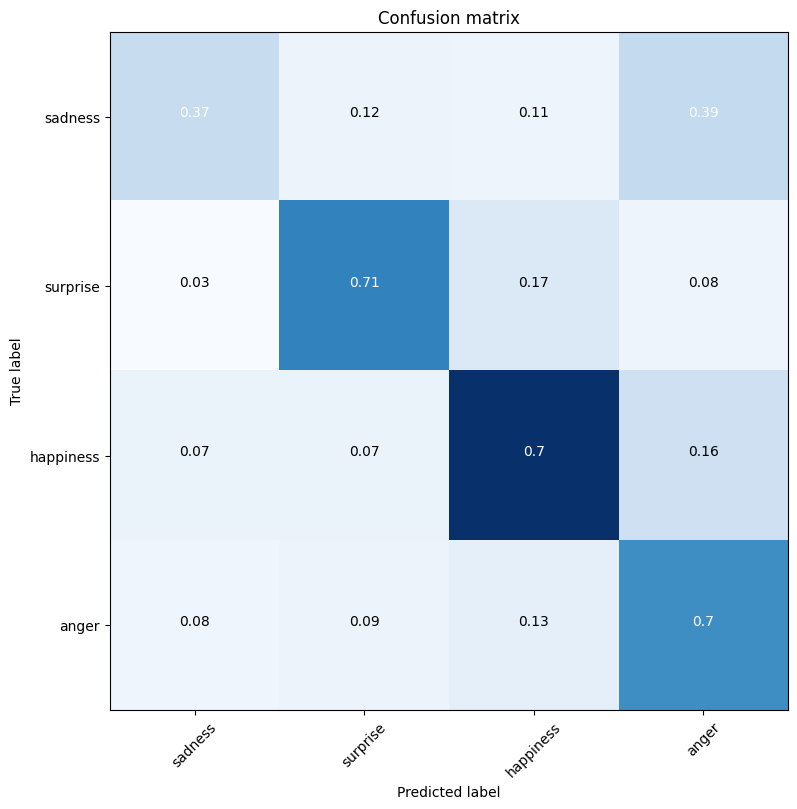

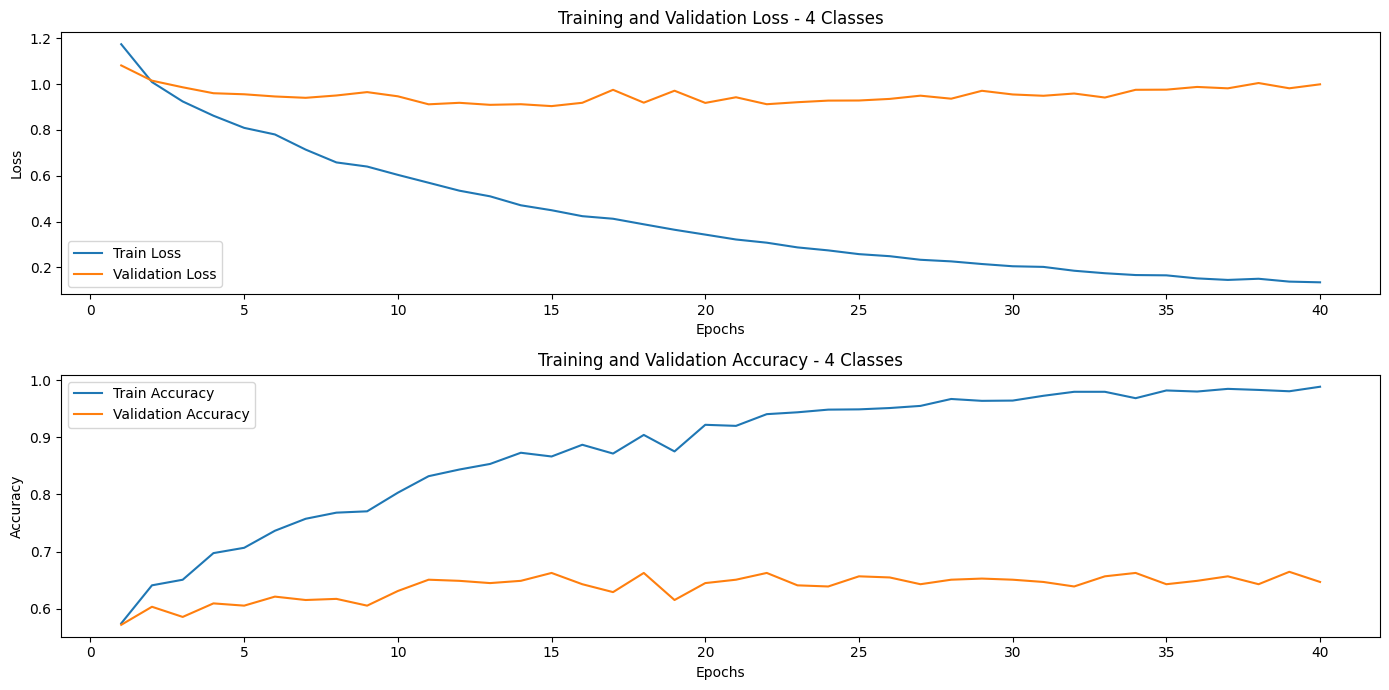

In [123]:
# Residual block model with balanced data
use_cuda = True
combined_model = CNNetResidual3(4,8,12)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=40, num_classes=4)

Training Begin...

Epoch 1: Train Acc: 0.45, Train Loss: 1.3626 | Val Acc: 0.44, Val Loss: 1.2535
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch0
Epoch 2: Train Acc: 0.50, Train Loss: 1.1869 | Val Acc: 0.51, Val Loss: 1.1478
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch1
Epoch 3: Train Acc: 0.50, Train Loss: 1.1020 | Val Acc: 0.50, Val Loss: 1.1215
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch2
Epoch 4: Train Acc: 0.55, Train Loss: 1.0717 | Val Acc: 0.55, Val Loss: 1.0629
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch3
Epoch 5: Train Acc: 0.56, Train Loss: 1.0327 | Val Acc: 0.56, Val Loss: 1.0623
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch4
Epoch 6: Train Acc: 0.58, Train Loss: 0.9887 | Val 

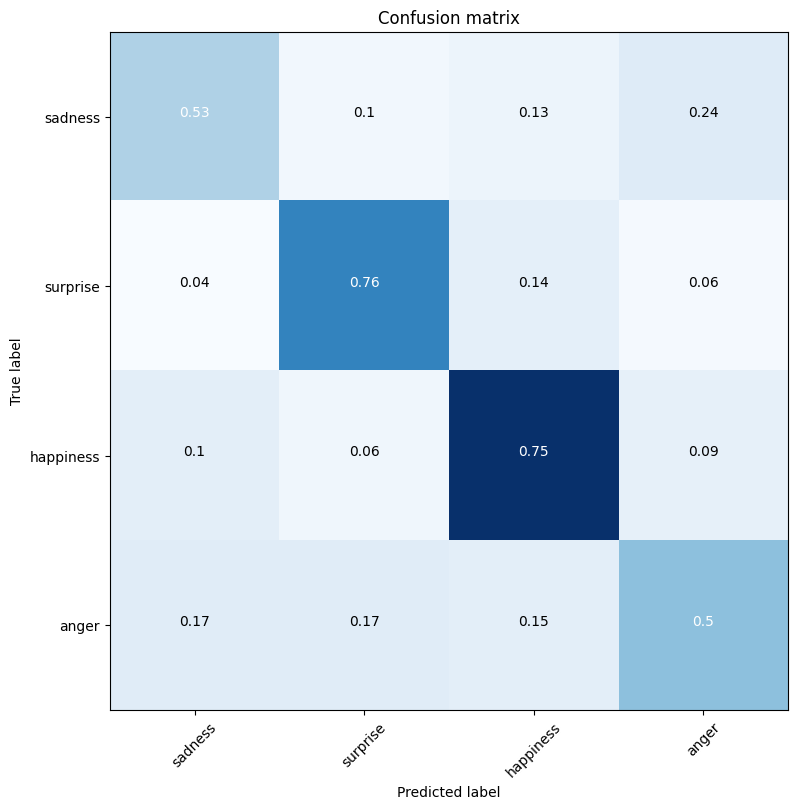

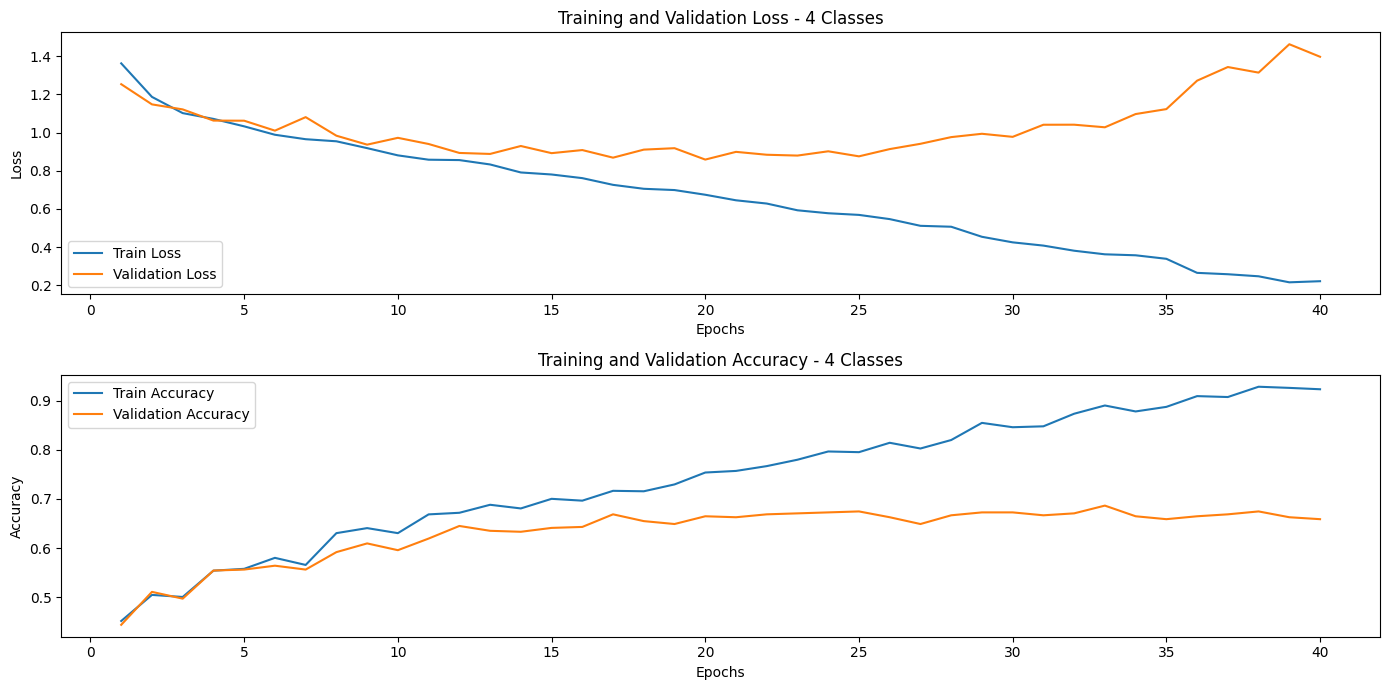

In [118]:
# Normal CNN with balanced data
use_cuda = True
combined_model = CombinedCNN(4)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=40, num_classes=4)

Training Begin...

Epoch 1: Train Acc: 0.42, Train Loss: 1.3450 | Val Acc: 0.41, Val Loss: 1.3195
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch0
Epoch 2: Train Acc: 0.51, Train Loss: 1.2395 | Val Acc: 0.49, Val Loss: 1.1709
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch1
Epoch 3: Train Acc: 0.54, Train Loss: 1.1065 | Val Acc: 0.55, Val Loss: 1.0998
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch2
Epoch 4: Train Acc: 0.56, Train Loss: 1.0392 | Val Acc: 0.53, Val Loss: 1.0615
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch3
Epoch 5: Train Acc: 0.60, Train Loss: 1.0331 | Val Acc: 0.58, Val Loss: 1.0237
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0001_epoch4
Epoch 6: Train Acc: 0.60, Train Loss: 0.9786 | Val 

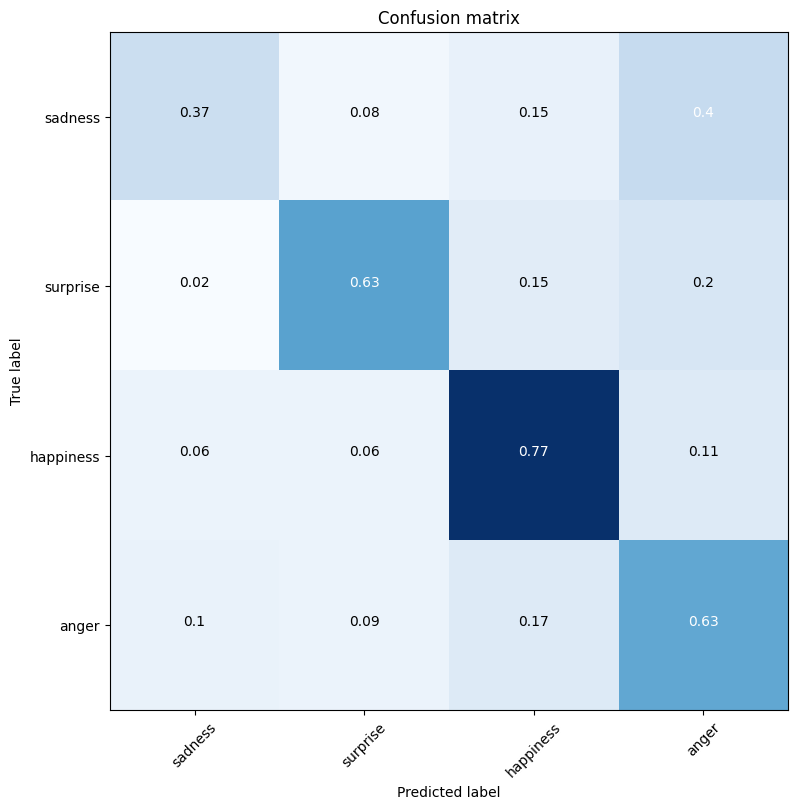

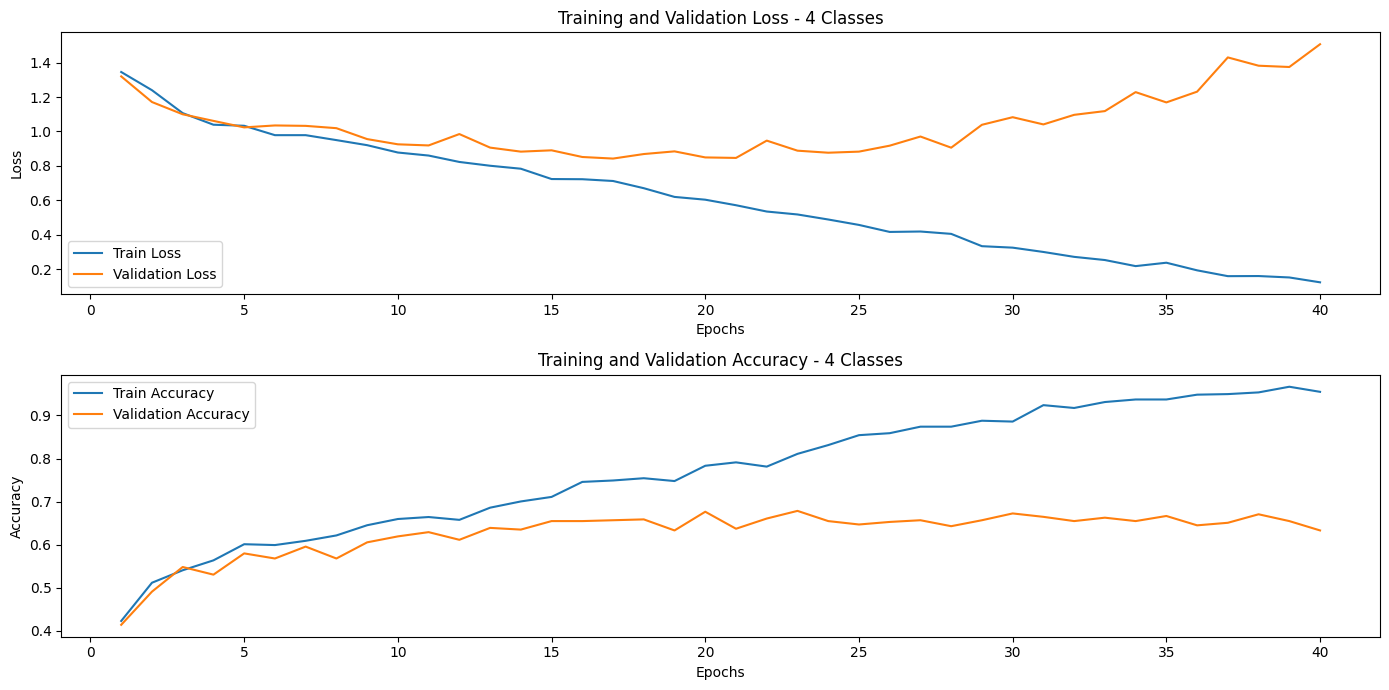

In [124]:
# Normal CNN with unbalanced data
use_cuda = True
combined_model = CombinedCNN(4)
combined_model.cuda()
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=40, num_classes=4)

In [125]:
# load your best model
best_model4class = CombinedCNN(4)
best_model4class.cuda()
best_model4class.load_state_dict(torch.load('/content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN4class69_bs64_lr0.0001_epoch32.pt'))

<All keys matched successfully>

In [126]:
test_acc = testevaluate(best_model4class, combined_test_dataset)
print("Test Acc {:.2f}%".format(test_acc))

Test Acc 0.65%


# Quantitative Results for 8 classes
The best accuracy for 4 classes is balance data with normal CNN model, best validation accuracy 0.69, with corresponding test data accuracy 0.65. The correspoding unbalance data has best validation accuracy 0.67. But the model with residual block's accuracy is slighter lower then normal CNN model, with best accuracy 0.67. We surpringly find balanced data set does not increase total accuracy much. But it indeed change some emotion accuracy. Before the data has been balanced the accuracy for Sade, surprise , happy and anger emotion is 0.37, 0.63, 0.77, 0.63. After balance the corresponding accuracy has been changed to 0.53, 0.76, 0.75, 0.5.

In [130]:
# Four classes: neutrality, sadness, fear, anger
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_or_array)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_or_array.shape)
print("Filtered Labels Shape:", labels_or_array.shape)

Label 0 neutrality: 419 images
Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 3 surprise: 610 images
Label 4 contempt: 142 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Label 7 disgust: 292 images
Filtered Features Shape: (3764, 224, 224)
Filtered Labels Shape: (3764,)


In [128]:
# Prepare datasets for eyes, eyebrows, and mouth
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_or_array, labels_or_array, transform)

# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (neutrality): 537 images
Label 1 (sadness): 537 images
Label 2 (fear): 537 images
Label 3 (surprise): 537 images
Label 4 (contempt): 537 images
Label 5 (happiness): 537 images
Label 6 (anger): 537 images
Label 7 (disgust): 537 images


Training Begin...

Epoch 1: Train Acc: 0.38, Train Loss: 1.8692 | Val Acc: 0.38, Val Loss: 1.7200
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.43, Train Loss: 1.6722 | Val Acc: 0.42, Val Loss: 1.6473
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.46, Train Loss: 1.5753 | Val Acc: 0.41, Val Loss: 1.6384
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.49, Train Loss: 1.4943 | Val Acc: 0.42, Val Loss: 1.6014
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.50, Train Loss: 1.4313 | Val Acc: 0.41, Val Loss: 1.6082
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual3_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.54, Train Loss: 1.3

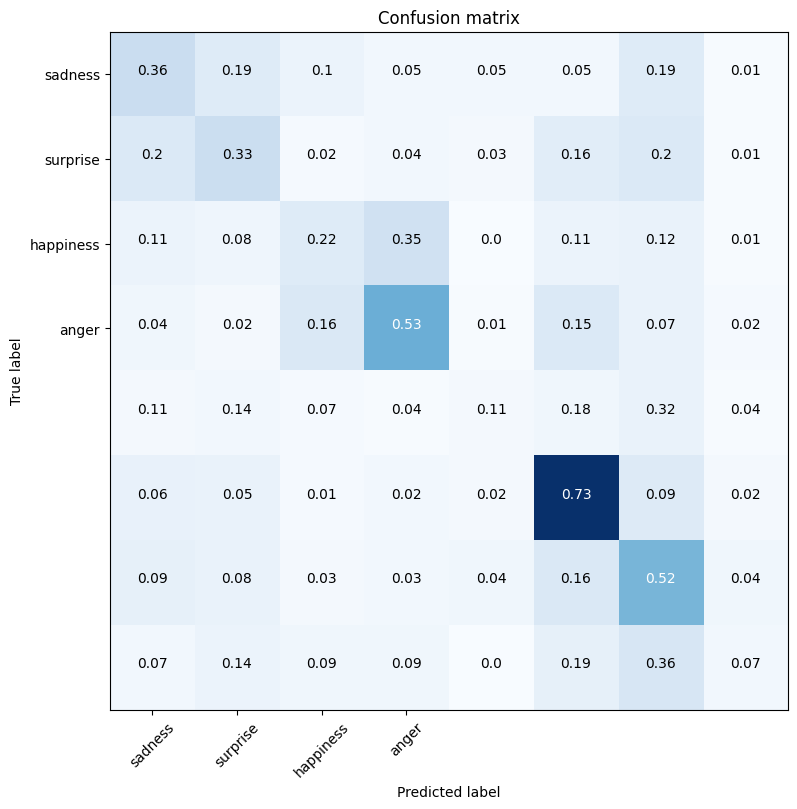

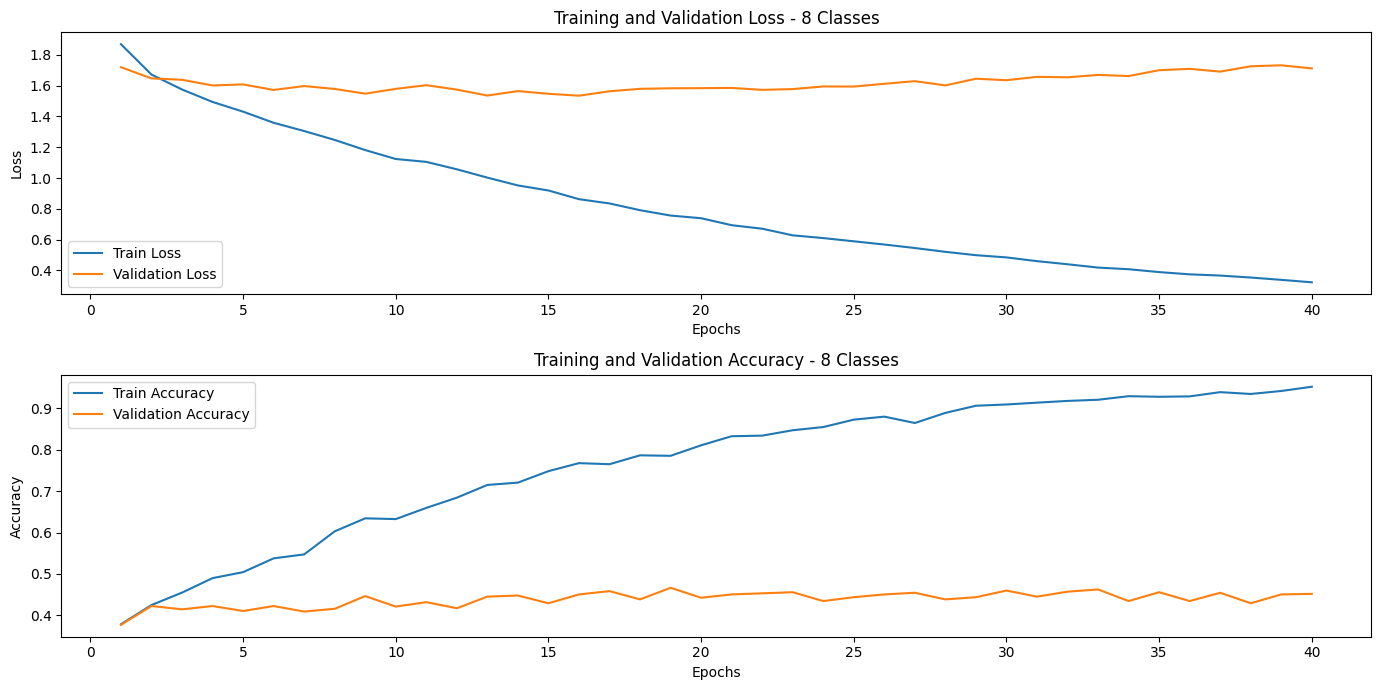

In [131]:
use_cuda = True
combined_model = CNNetResidual3(8,16,16)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=40, num_classes=8)

In [132]:
use_cuda = True
combined_model = CombinedCNN(8)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=40, num_classes=8)

Training Begin...

Epoch 1: Train Acc: 0.17, Train Loss: 2.0778 | Val Acc: 0.27, Val Loss: 2.0629
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.22, Train Loss: 2.0602 | Val Acc: 0.29, Val Loss: 2.0043
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.27, Train Loss: 1.9721 | Val Acc: 0.30, Val Loss: 1.9025
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.31, Train Loss: 1.8775 | Val Acc: 0.34, Val Loss: 1.8120
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.32, Train Loss: 1.8343 | Val Acc: 0.36, Val Loss: 1.7897
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.33, Train Loss: 1.7982 | Val Acc: 

KeyboardInterrupt: ignored

In [21]:
def crop_and_resize_faces(root_folder, target_size=(224, 224)):
    image_data = []  # List to store resized image data
    image_labels = []  # List to store image labels (file names)

    # Create a face detector from dlib
    face_detector = dlib.get_frontal_face_detector()

    # Iterate through all subfolders in the root folder
    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)

        # Check if the item in the root folder is a directory
        if os.path.isdir(folder_path):
            # Iterate through all files in the subfolder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Check if the file is an image
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                    # Read the image using OpenCV
                    image = cv2.imread(file_path)

                    # Convert the BGR image to RGB
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Detect faces in the image
                    faces = face_detector(image_rgb)

                    # Check if any faces are detected
                    if len(faces) > 0:
                        # Get the bounding box of the first face
                        face_bbox = faces[0]

                        # Crop the face from the image
                        cropped_face = image_rgb[face_bbox.top():face_bbox.bottom(), face_bbox.left():face_bbox.right()]

                        # Resize the cropped face
                        resized_face = cv2.resize(cropped_face, target_size)

                        # Extract label name without file extension and convert to lowercase
                        label = os.path.splitext(file_name)[0].lower()

                        # Append resized face and label to lists
                        image_data.append(Image.fromarray(resized_face))
                        image_labels.append(label)

    return image_data, image_labels

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

# Specify the root folder containing subfolders with images
root_folder = '/content/gdrive/My Drive/ColabNotebooks/origina'

# Read, crop, and resize faces, and get labels
cropped_and_resized_faces, labels = crop_and_resize_faces(root_folder)
label_mapping = {
    'neutral': 0,
    'sad': 1,
    'fear': 2,
    'surprised': 3,
    'contempt': 4,
    'happy': 5,
    'anger': 6,
    'disgust': 7
}

# Update the labels using the mapping
updated_labels = [label_mapping[label] for label in labels]


Number of images processed: 79
Image neutral - Resized Size: 224x224 pixels
Image happy - Resized Size: 224x224 pixels
Image anger - Resized Size: 224x224 pixels
Image disgust - Resized Size: 224x224 pixels
Image surprised - Resized Size: 224x224 pixels
Image sad - Resized Size: 224x224 pixels
Image contempt - Resized Size: 224x224 pixels
Image fear - Resized Size: 224x224 pixels
Image sad - Resized Size: 224x224 pixels
Image disgust - Resized Size: 224x224 pixels
Image anger - Resized Size: 224x224 pixels
Image happy - Resized Size: 224x224 pixels
Image surprised - Resized Size: 224x224 pixels
Image contempt - Resized Size: 224x224 pixels
Image fear - Resized Size: 224x224 pixels
Image neutral - Resized Size: 224x224 pixels
Image happy - Resized Size: 224x224 pixels
Image anger - Resized Size: 224x224 pixels
Image disgust - Resized Size: 224x224 pixels
Image surprised - Resized Size: 224x224 pixels
Image sad - Resized Size: 224x224 pixels
Image neutral - Resized Size: 224x224 pixels
I

In [28]:
label_mapping = {
    'neutral': 0,
    'sad': 1,
    'fear': 2,
    'surprised': 3,
    'contempt': 4,
    'happy': 5,
    'anger': 6,
    'disgust': 7
}

# Convert labels to integers
labels_as_int = [label_mapping[label] for label in labels]


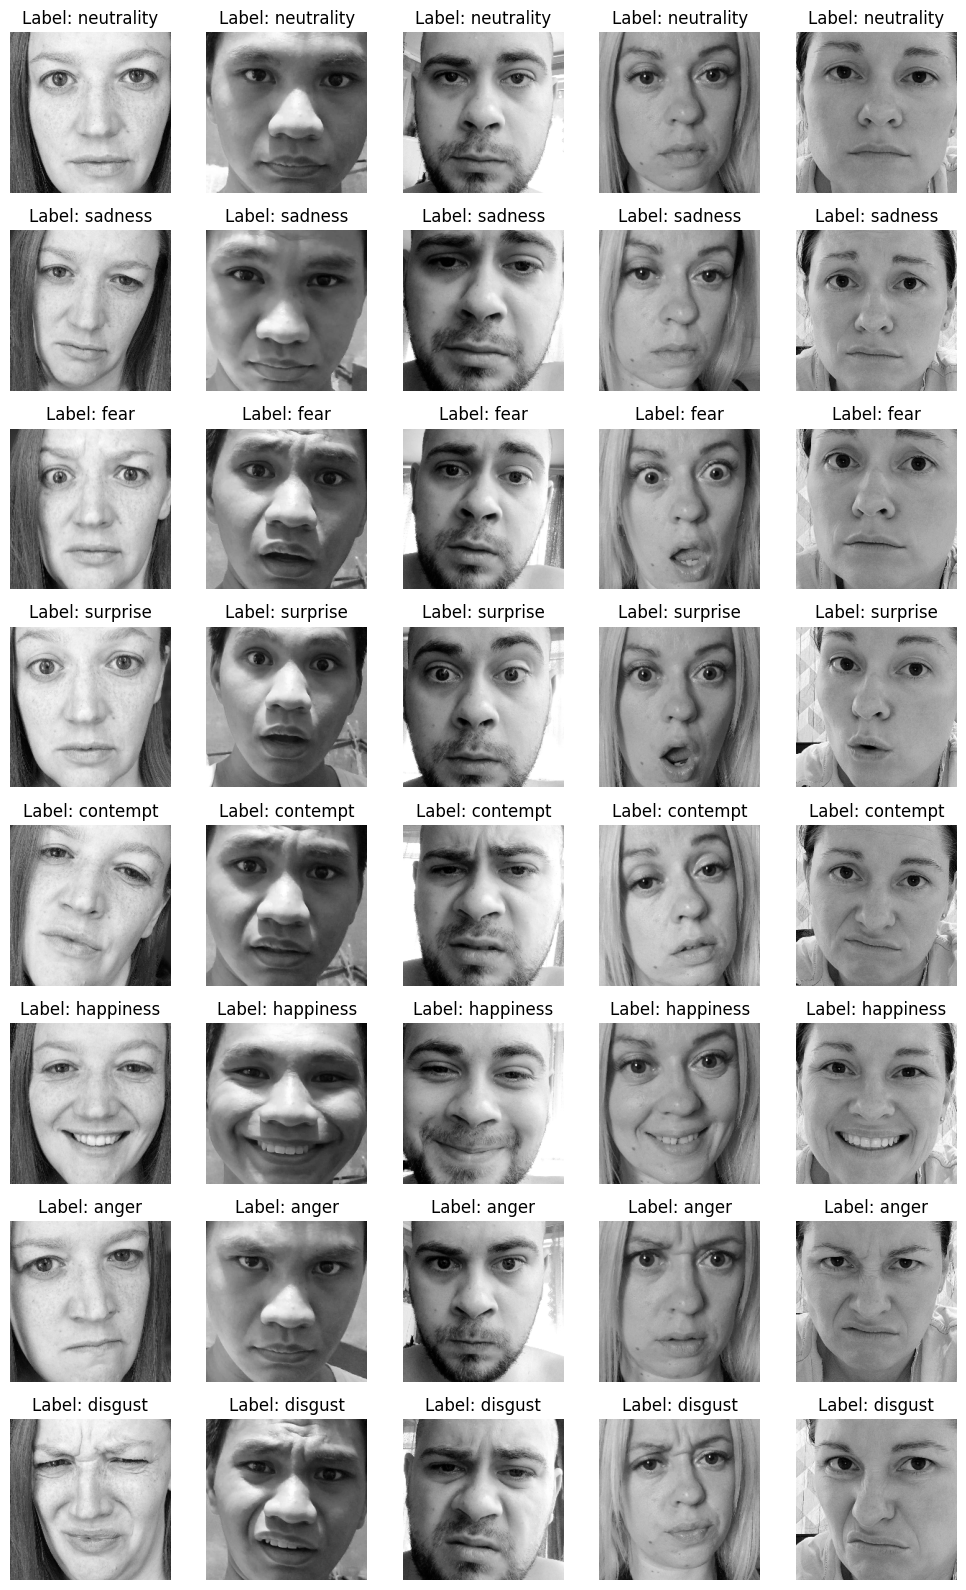

In [31]:
cropped_and_resized_faces_gray = [image.convert('L') for image in cropped_and_resized_faces]
plot_first_n_images(cropped_and_resized_faces_gray, labels_as_int, classeses, n=5)

In [49]:
extracted_regions_new = []
features_new = []
labels_new = []
train_data_new = []
failed_indices_new = []

def create_imagesnew():
    for i, gray_image in enumerate(cropped_and_resized_faces_gray):
        label = labels_as_int[i]  # Use the index of the class as the label

        # Ensure that gray_image is a numpy array
        gray_image_np = np.array(gray_image)

        # Apply CLAHE to improve the contrast locally
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_clahe = clahe.apply(gray_image_np)

        # Detect faces in the CLAHE preprocessed image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if len(faces) == 0:
            gray_eq = cv2.equalizeHist(gray_image_np)
            faces = detector(gray_eq, 1)
            image_to_use = gray_eq
        else:
            image_to_use = gray_clahe

        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(image_to_use, face)
            combined_region = extract_and_combine_regions(image_to_use, landmarks)

            # Append the combined image and its label to the list
            features_new.append(combined_region)  # Append the combined region
            labels_new.append(label)

            train_data_new.append([combined_region, label])
        else:
            failed_indices_new.append(i)

create_imagesnew()



In [51]:
label_counts = Counter(labels_new)
for label, count in label_counts.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 9 images
Label 5 happiness: 9 images
Label 6 anger: 8 images
Label 7 disgust: 10 images
Label 3 surprise: 10 images
Label 1 sadness: 8 images
Label 4 contempt: 10 images
Label 2 fear: 10 images


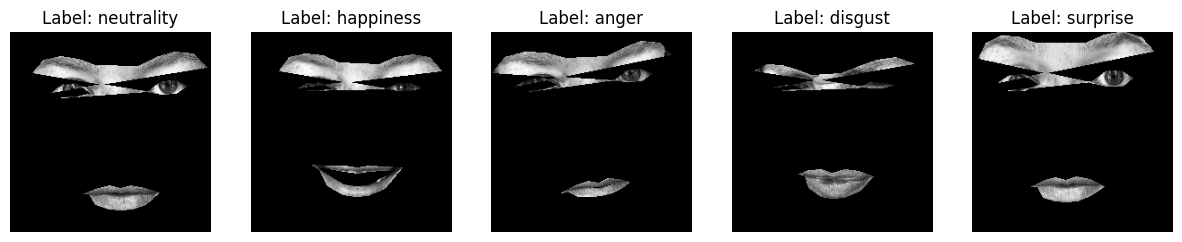

In [140]:
def plot_first_n_images(images, labels, classes, n):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))

    # Plot the first n images
    for img_idx, img_index in enumerate(range(n)):
        axes[img_idx].imshow(images[img_index], cmap='gray')
        axes[img_idx].set_title(f"Label: {classes[labels[img_index]]}")
        axes[img_idx].axis('off')

    plt.show()

# Example usage
plot_first_n_images(features_new, labels_new, classeses, n=5)


In [175]:
# Four classes: sadness, surprise, anger，happy
features_or_array_new = np.array(features_new)  # Convert features to a NumPy array for indexing
labels_or_array_new = np.array(labels_new)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels_new = [1, 3, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array_new, desired_labels_new)

# Extract features and labels corresponding to the desired labels
features_filtered_new = features_or_array_new[mask]
labels_filtered_new = labels_or_array_new[mask]

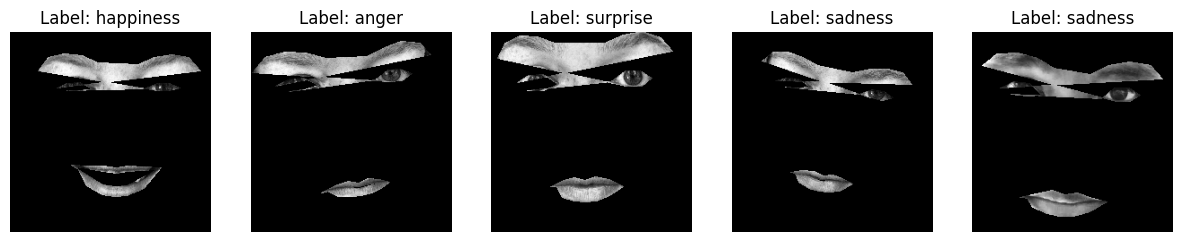

In [176]:
plot_first_n_images(features_filtered_new, labels_filtered_new, classeses, n=5)

In [177]:
labels_filtered_new = np.array(labels_filtered_new)

# Change value 1 to 0 and value 5 to 1
labels_filtered_new[labels_filtered_new == 1] = 0
labels_filtered_new[labels_filtered_new == 3] = 1
labels_filtered_new[labels_filtered_new == 5] = 2
labels_filtered_new[labels_filtered_new == 6] = 3
np.unique(labels_filtered_new)

array([0, 1, 2, 3])

In [178]:
test_new = prepare_dataset(features_filtered_new, labels_filtered_new, transform)

In [179]:
use_cuda = True
best_model4class.cuda()
test_acc = testevaluate(best_model4class, test_new)
print("Test Acc {:.2f}%".format(test_acc))


Test Acc 0.31%


In [168]:
# Four classes: sadness, surprise, anger，happy
features_or_array_new = np.array(features_new)  # Convert features to a NumPy array for indexing
labels_or_array_new = np.array(labels_new)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels_new = [1,5]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array_new, desired_labels_new)

# Extract features and labels corresponding to the desired labels
features_filtered_new = features_or_array_new[mask]
labels_filtered_new = labels_or_array_new[mask]

In [169]:
labels_filtered_new = np.array(labels_filtered_new)

# Change value 1 to 0 and value 5 to 1
labels_filtered_new[labels_filtered_new == 1] = 0
labels_filtered_new[labels_filtered_new == 5] = 1
np.unique(labels_filtered_new)

array([0, 1])

In [170]:
test_new = prepare_dataset(features_filtered_new, labels_filtered_new, transform)

In [171]:
use_cuda = True
best_model2class.cuda()
test_acc = testevaluate(best_model2class, test_new)
print("Test Acc {:.2f}%".format(test_acc))

Test Acc 1.00%


# Citation

1. Huang, Z. Y., Chiang, C. C., Chen, J. H., et al. (2023).
A study on computer vision for facial emotion recognition.
Scientific Reports, 13, 8425.
https://doi.org/10.1038/s41598-023-35446-4

2. Yolcu, G., Oztel, I., Kazan, S., Oz, C., Palaniappan, K., Lever, T. E., & Bunyak, F. (2019).
Facial expression recognition for monitoring neurological disorders based on convolutional neural network.
Multimedia Tools and Applications, 78(22), 31581-31603.
https://doi.org/10.1007/s11042-019-07959-6

3. Jain, D. K., Shamsolmoali, P., & Sehdev, P. (2019).
Extended deep neural network for facial emotion recognition.
Pattern Recognition Letters, 120, 69-74.
https://doi.org/10.1016/j.patrec.2019.01.008

4. Teixeira Lopes, A., de Aguiar, E., De Souza, A. F., & Oliveira-Santos, T. (2017).
Facial expression recognition with Convolutional Neural Networks: Coping with few data and the training sample order.
Pattern Recognition, 61, 610-628.
https://doi.org/10.1016/j.patcog.2016.07.026

5. Mellouk, W., & Handouzi, W. (2020). Facial emotion recognition using deep learning: review and insights. Procedia Computer Science, 175, 689-694.
https://doi.org/10.1016/j.procs.2020.07.101